# Analyze and filter DBTL1 recommendations
Filter the recommendations for DBTL1. `art_modeling_and_recommend_DBTL1` produced a dataframe consisting of every combination of 5 gRNAs, along with ART-predicted mean and std predictions for titer. Here, I'll filter and sort the recommendations based on a few criteria:
- changing exploration vs exploitation - Different recommendations will look better or worse based on whether we want to priorities exploration or exploitation
- Different requested numbers of 2-, 3-, 4-, and 5-gRNA recommendations - Experimental collaborators may want different numbers of each.
- Different levels of variety in gRNA - It's possible that ART identified two gRNAs (A and B, for instance) that it considers optimal, and every high-ranking recommendation for 3-gRNA strains will look like A + B + X. In this case, we may want to filter out some of these recommendations.

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../art/'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
fig_loc = './dbtl1_figures/'

## Import `rec_df` and `data_df`

In [4]:
rec_df = pd.read_pickle('./dbtl1_figures/DBTL1_rec_df.pkl')

In [5]:
rec_df.head(3)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.074370,52.465324
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.340764,52.332249
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.272903,52.341082


In [6]:
pert_columns = rec_df.columns[:-2]

In [7]:
data_df = pd.read_pickle('./dbtl1_figures/dbtl0_dbtl1_isoprenol_processed_df.pkl')

In [8]:
data_df.head(3)

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],...,0,0,0,0,0,0,0,0,0,False


## Characterize Recommendations

### Plot distributions of mean and std
Here we will visualize how the recommendations compare to the training data distribution.

Compare predicted titer for all recommendations against the titer of the training data

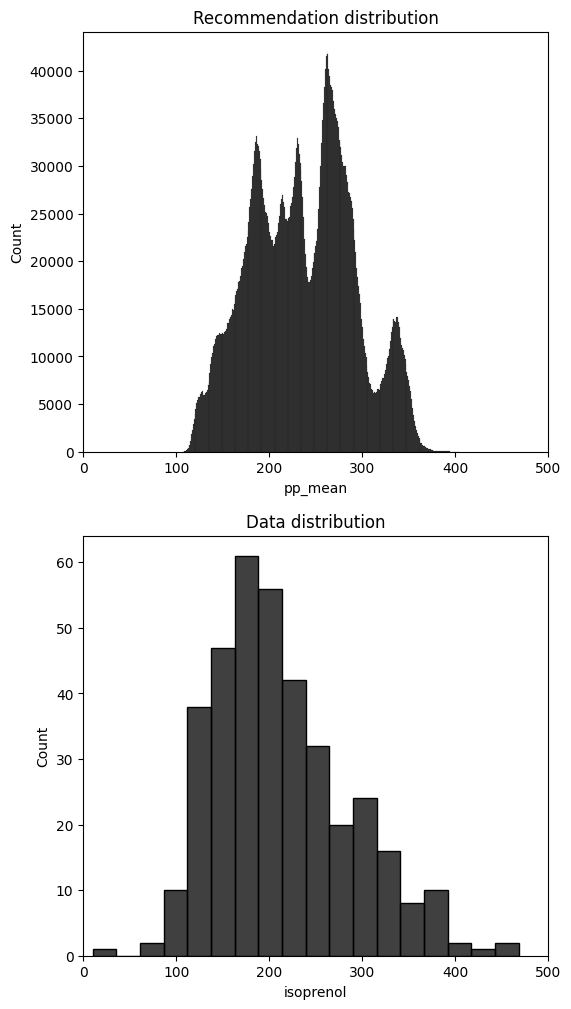

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,12))
sns.histplot(data = rec_df, x = 'pp_mean', color = 'k', ax = ax[0])
sns.histplot(data = data_df[data_df['has_cycle1_gene']], x = 'isoprenol', color = 'k', ax = ax[1])
ax[0].set_title('Recommendation distribution')
ax[0].set_xlim([0, 500])
ax[1].set_title('Data distribution')
ax[1].set_xlim([0, 500])
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_filled_hist.png')

Same as above, but with overlayed kernel density estimates.

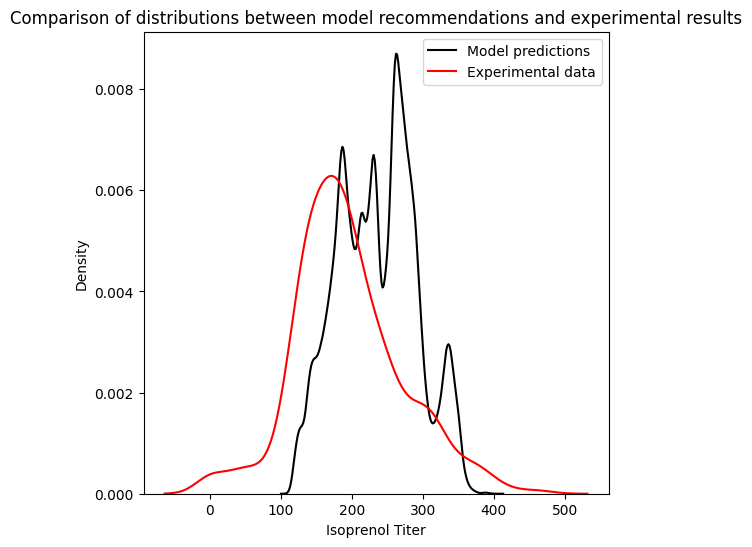

In [11]:
fig, ax = plt.subplots(figsize = (6,6))
sns.kdeplot(data=rec_df, x="pp_mean", ax = ax, color = 'k')
sns.kdeplot(data = data_df, x = 'isoprenol', ax = ax, color = 'r')
ax.set_xlabel('Isoprenol Titer')
plt.legend(['Model predictions', 'Experimental data'])
plt.title('Comparison of distributions between model recommendations and experimental results')
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_kde.png')

Same as above, but with overlayed empty histograms.

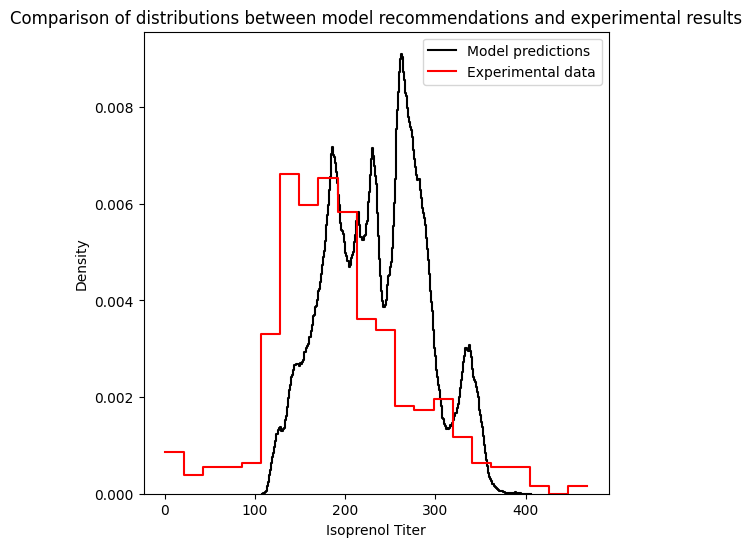

In [12]:
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(data=rec_df, x="pp_mean", ax = ax, color = 'k', fill=False, element = 'step', stat = 'density')
sns.histplot(data = data_df, x = 'isoprenol', ax = ax, color = 'r', fill = False, element = 'step', stat = 'density')
ax.set_xlabel('Isoprenol Titer')
plt.legend(['Model predictions', 'Experimental data'])
plt.title('Comparison of distributions between model recommendations and experimental results')
fig.savefig(fig_loc + 'compare_rec_and_data_distribution_step_hist.png')

Plot the distribution of mean and std for recommendations.

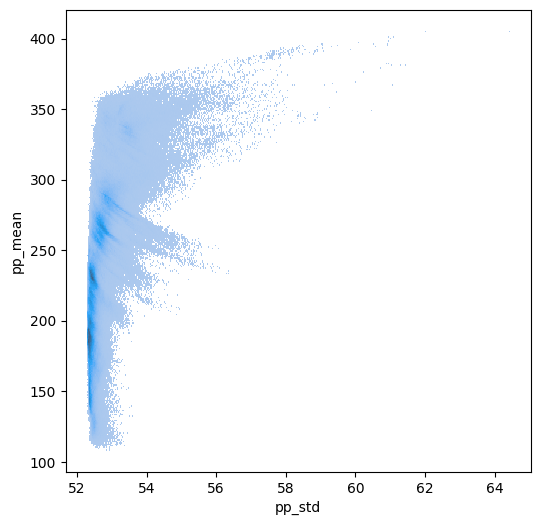

In [13]:
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(data = rec_df, x = 'pp_std', y = 'pp_mean')
fig.savefig(fig_loc + 'recommendation_joint_mean_std_histogram.png')

Plot the distribution of mean and std as individual distributions. 

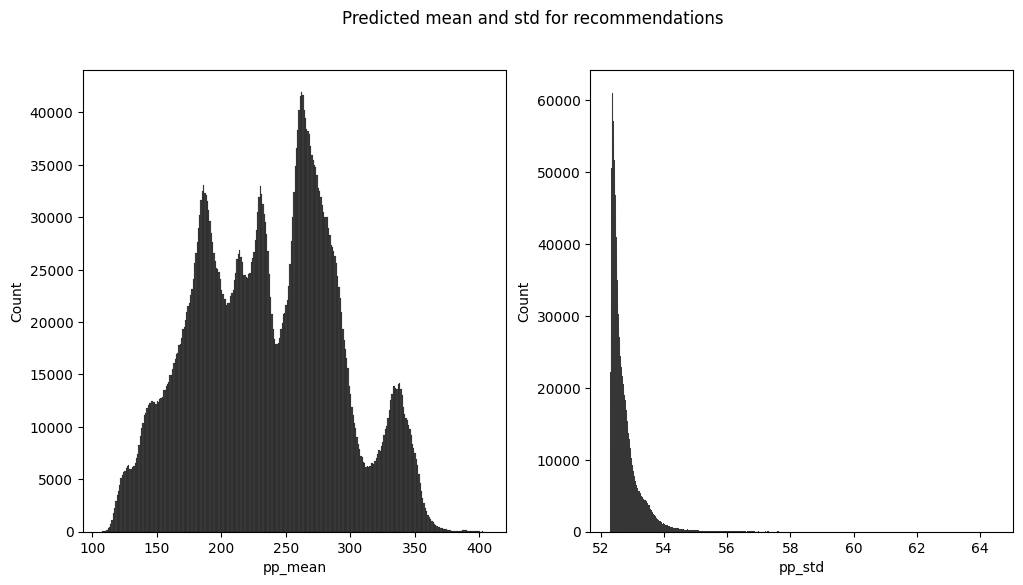

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.histplot(data = rec_df, x = 'pp_mean', color = 'k', ax = ax[0])
sns.histplot(data = rec_df, x = 'pp_std', color = 'k', ax = ax[1])
plt.suptitle('Predicted mean and std for recommendations')
fig.savefig(fig_loc + 'recommendation_dist_mean_and_std.png')

### Break distributions down by number of gRNA

In [15]:
rec_df['number_of_grna'] = rec_df.loc[:, pert_columns].apply(sum, axis = 1).astype(int)

In [16]:
rec_df.head(3)

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std,number_of_grna
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.074370,52.465324,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.340764,52.332249,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.272903,52.341082,1


Distributions of mean and std split up by number of gRNA

<Axes: xlabel='number_of_grna', ylabel='pp_mean'>

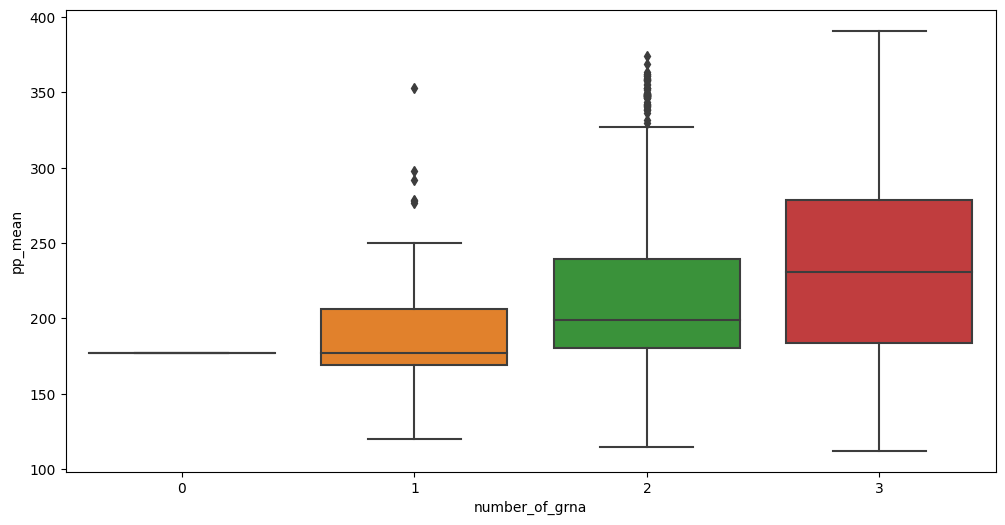

In [21]:
fig, ax = plt.subplots( figsize=(12,6))

sns.boxplot(data = rec_df.loc[:10000,:], y = 'pp_mean', x = 'number_of_grna', ax = ax)


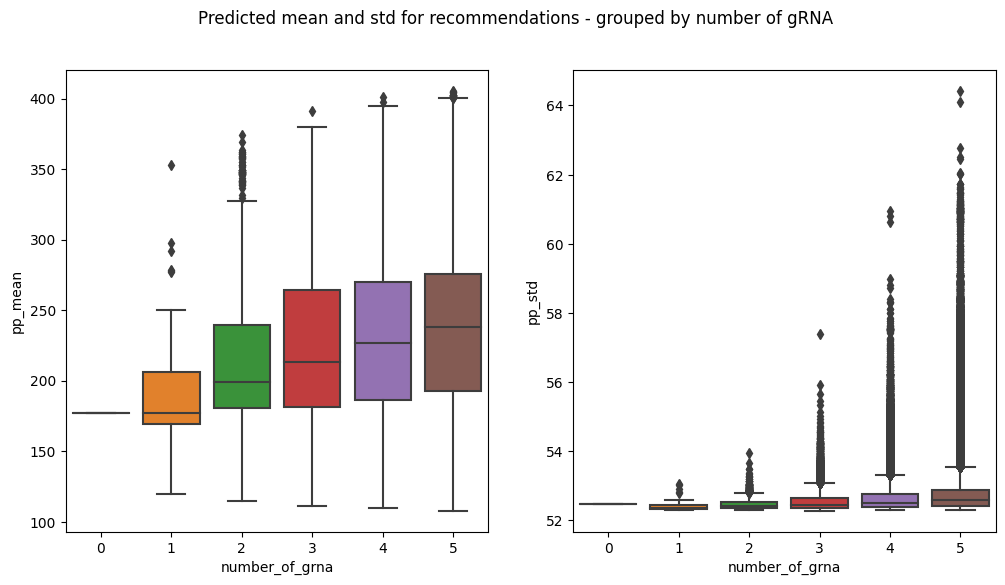

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,6))
sns.boxplot(data = rec_df, y = 'pp_mean', x = 'number_of_grna', ax = ax[0])
sns.boxplot(data = rec_df, y = 'pp_std', x = 'number_of_grna', ax = ax[1])
plt.suptitle('Predicted mean and std for recommendations - grouped by number of gRNA')
fig.savefig(fig_loc + 'recommendation_dist_mean_and_std_gRNA_num_grouping.png')

## Filter recommendations

In [ ]:
alpha = 0.5